# Classification

## 1. Introduction

Classification involves choosing between a discrete set of outcomes. You can think of this as having a set of buckets, and our goal is to choose a single bucket based on the input. For example, we might feed an image into a neural network as an input, and the output might be whether it contains a cat or a dog. Another example might be feeding in blood test results, and then determining if a person has diabetes or not.

As with regression, classification makes use of a cost function, though whereas regression tends to maximize the log-probability of the Normal distribution, classification typically uses either the multinomial log-likelihood, or the cross-entropy loss function (more on this a bit later).

For classification, the function we use is typically either the sigmoid (or logit) function or the softmax function. The sigmoid function takes the form:

\begin{equation}
\sigma(z) = \frac{1}{1+e^{-z}}
\end{equation}

And can be interpreted as $P(Y=1|X=x)$. To visualize this, we'll plot it below:

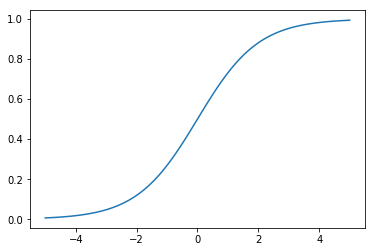

In [1]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

sigmoid = lambda z : 1/(1+np.exp(-z))

xs = np.linspace(-5, 5, 100)
ys = sigmoid(xs)
ax = plt.axes()
ax.plot(xs, ys)
plt.show()

The sigmoid function takes the value of $y=0.5$ at $z=0$. In general, if $y \geq 0.5$, then we set $y=1$, otherwise we set $y=0$. 

## 2. Logistic Regression
Fitting a classifier using the sigmoid function is known as logistic regression, and is done by setting $z = \mathbf{\Theta^{T}X}$. As a simple exercise, let's assume that we have the following noisy dataset:

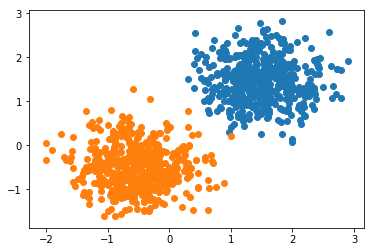

In [2]:
import random

mux_1, stdx_1 = 1.5, 0.5
muy_1, stdy_1 = 1.5, 0.5

mux_2, stdx_2 = -0.5, 0.5
muy_2, stdy_2 = -0.5, 0.5

samples = 500

x_1 = np.array([random.gauss(mux_1, stdx_1) for _ in range(samples)])
y_1 = np.array([random.gauss(muy_1, stdy_1) for _ in range(samples)])

x_2 = np.array([random.gauss(mux_2, stdx_2) for _ in range(samples)])
y_2 = np.array([random.gauss(muy_2, stdy_2) for _ in range(samples)])

ax = plt.axes()
ax.scatter(x_1, y_1)
ax.scatter(x_2, y_2)
plt.show()

In this case, we have two distinct populations, and if we have an x and y, we want to know if it belongs to population A or population B. Let's set this up as a logistic regression exercise, where our features are the x and y values. We'll relabel x and y to be $x_1$ and $x_2$, and we'll add an $x_0 = 1$ to our feature vector $\mathbf{X}$. We'll train our classifier to output 1 if the features indicate the sample is in population A, and 0 if it is population B. The following code uses two outputs t represent $[0, 1]$ and $[1, 0]$, but in this case we could also use a single output that can only be $1$ or $0$:

In [3]:
features = np.hstack([np.vstack([np.ones(x_1.shape), x_1, y_1]), 
                      np.vstack([np.ones(x_2.shape), x_2, y_2])])

labels = np.vstack([np.hstack([np.ones(x_1.shape), np.zeros(x_2.shape)]),
                    np.hstack([np.zeros(x_1.shape), np.ones(x_2.shape)])])

Our cost function is called the binary cross entropy loss, which corresponds to the log-probability of the binomial probability distribution:

\begin{equation}
\mathcal{L} = \frac{1}{N}\sum_{i=1}^{N}-y_{i}\log{h(x_{i})}-(1-y_{i})(1-h(x_{i}))
\end{equation}

Essentially, we are maximizing the log-likelihood that the prediction of our classifier is correct given that our outputs are limited to 0 and 1. We implement this cost function below:

In [4]:
def cost(theta, x, y):
    h = sigmoid(theta.reshape(2,-1).dot(x))
    loss = (-y*np.log(h)-(1-y)*np.log(1-h)).mean()
    return loss

Next, we'll optimize our theta values to predict the output. In this case, we will use 6 weighting parameters, to produce two outputs. In a sense, this is a very small (single layer) neural network. We'll use a standard scipy optimizer to do the heavy lifting for us. In this case, we'll use the conjugate gradient method, and place a tolerance on the loss function (if we don't, the loss will eventually explode): 

In [5]:
from scipy.optimize import minimize

theta_0 = np.random.randn(2,3)
theta = minimize(cost, theta_0, args=(features, labels), method="CG", tol=1e-3)
print("Found weight parameters: {}".format(theta.x))

pred = sigmoid(np.array(theta.x).reshape(2,-1).dot(features))
pred = (pred >= 0.5)*1
print("Classifier accuracy: {:.5f}".format((pred == labels).mean()))

Found weight parameters: [-5.89680846  5.98789191  5.53270236  6.06368696 -6.22413334 -5.62040119]
Classifier accuracy: 0.99800


Testing the parameters, we've managed to achieve ~99% accuracy, which is pretty good! We can also plot the decision boundary to see where the classifier thinks the boundary between the two populations is. To do this, we find the coordinates at which the output probability is 0.5:

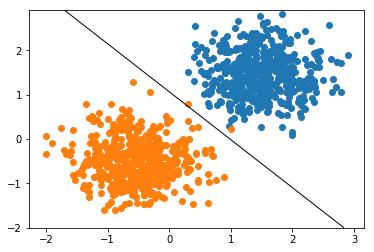

In [6]:
min_x_val = min(x_1.min(), x_2.min())
max_x_val = max(x_1.max(), x_2.max())

min_y_val = min(x_1.min(), x_2.min())
max_y_val = max(x_1.max(), x_2.max())

x_, y_ = np.meshgrid(np.linspace(min_x_val, max_x_val, 50), np.linspace(min_y_val, max_y_val, 50))

u = np.linspace(min_x_val, max_x_val, 50)
data = []
for i in range(50):
    v = y_[i,:]
    xs = np.array([np.ones(u.shape), u, v])
    p = sigmoid(np.array(theta.x).reshape(2,-1).dot(xs))
    data.append(p[0,:])
data = np.vstack(data)

ax = plt.axes()
ax.scatter(x_1, y_1)
ax.scatter(x_2, y_2)
plt.contour(x_, y_, data, [0.5], linewidths=1, colors='k')
plt.show()

As we can see, the boundary splits the two populations fairly accurately.

## 3. Using the Softmax Function

Another way to achieve the same outcome is to use the softmax function:

\begin{equation}
y_{i} = \frac{e^{x_{i}}}{\sum_{i=1}^{n}e^{x_{i}}}
\end{equation}

This function sums to 1 over all outputs, and is often interpreted as a categorical probability distribution. If we use this function, we change the prediction to the maximum output. Our loss function is the cross entropy function:

\begin{equation}
\mathcal{L} = \frac{1}{M}\sum_{i=1}^{M}-P(x)\log{Q(x)}
\end{equation}

Where $P(.)$ and $Q(.)$ are probability distributions. This function measures the amount of mutual information between the two distributions. It is the more general form of the binary cross entropy loss function we used earlier. Given that our labels $y^{*}$ are either 1 or 0, we can take this as the probability that an object (defined by its features) is in a given class $k$; likewise, the output $y$ of our classifier is the predicted probability that the object is in class $k$. This makes our loss function:

\begin{equation}
\mathcal{L} = \frac{1}{M}\sum_{i=1}^{M}-y_{i}^{*}\log{y_{i}}
\end{equation}

We can simplify this further by recognizing that -- since $y_{i}$ will only ever be zero or one -- this is simply:

\begin{equation}
\mathcal{L} = \frac{1}{M}\sum_{i=1}^{M}-\log{y_{i}}
\end{equation}

In [7]:
softmax = lambda x : np.exp(x)/np.sum(np.exp(x), axis=0)

def cost(theta, x, y):
    h = softmax(theta.reshape(2,-1).dot(x))
    loss = -np.mean(y*np.log(h))
    return loss
    
theta_0 = np.random.randn(2,3)
theta = minimize(cost, theta_0, args=(features, labels), method="CG", tol=1e-4)
print("Found weight parameters: {}".format(theta.x))

pred = softmax(np.array(theta.x).reshape(2,-1).dot(features))
print("Classifier accuracy: {:.5f}".format((np.rint(pred) == labels).mean()))

Found weight parameters: [-10.04319661   6.99498709   6.10010879   7.70292841  -6.97257793
  -9.1160496 ]
Classifier accuracy: 1.00000


We've cheated a little bit here and rounded the predicted probabilities to the nearest integer, when the more correct method is to select the maximum probability output. For this simplified example, however, the result is the same. As we can see, the accuracy is almost exactly the same as for the logit classifier. What's the advantage of one over the other? In some case, we may want to sample from a categorical distribution, in which case a softmax output is generally better. In reinforcement learning, for example, value-based methods can output a distribution over actions that can then be sampled from, which gives an elegant means of exploring an environment.

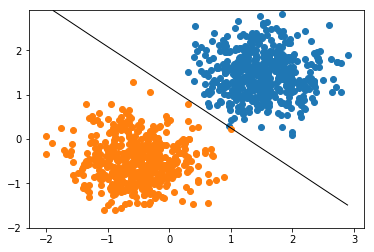

In [8]:
data = []
for i in range(50):
    v = y_[i,:]
    xs = np.array([np.ones(u.shape), u, v])
    p = softmax(np.array(theta.x).reshape(2,-1).dot(xs))
    data.append(p[0,:])
data = np.vstack(data)

ax = plt.axes()
ax.scatter(x_1, y_1)
ax.scatter(x_2, y_2)
plt.contour(x_, y_, data, [0.5], linewidths=1, colors='k')
plt.show()

As we can see, we get almost the exact same result as for when we used the logit function.

Which one of these should you use, and when? In general, they can be used interchangeably for many tasks. I typically softmax functions when I want to be able to sample from a distribution -- i.e. when selecting actions in reinforcement learning tasks. For that reason, I tend to favour the softmax formulation over the logit one.

## 4. Linear Separability
One potential hiccup to be aware of is the potential for unseparable datasets. For example, consider the following data:

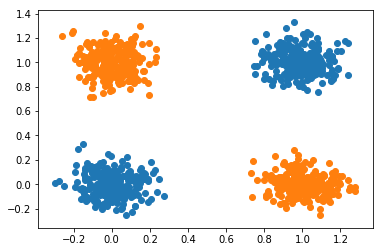

In [9]:
samples = 250

x_1 = np.array([random.gauss(0, 0.1) for _ in range(samples)])
y_1 = np.array([random.gauss(0, 0.1) for _ in range(samples)])

x_2 = np.array([random.gauss(1, 0.1) for _ in range(samples)])
y_2 = np.array([random.gauss(0, 0.1) for _ in range(samples)])

x_3 = np.array([random.gauss(0, 0.1) for _ in range(samples)])
y_3 = np.array([random.gauss(1, 0.1) for _ in range(samples)])

x_4 = np.array([random.gauss(1, 0.1) for _ in range(samples)])
y_4 = np.array([random.gauss(1, 0.1) for _ in range(samples)])

x1, y1 = np.hstack([x_1, x_4]), np.hstack([y_1, y_4])
x2, y2 = np.hstack([x_2, x_3]), np.hstack([y_2, y_3])

ax = plt.axes()
ax.scatter(x1, y1)
ax.scatter(x2, y2)
plt.show()

In this case, there is no line that can be drawn to separate the two populations -- i.e. it is not linearly separable. The example given is known as the XOR logic gate. To classify problems such as this one, we need to use non-linear feature inputs: 

In [10]:
from scipy.optimize import minimize

softmax = lambda x : np.exp(x)/np.sum(np.exp(x), axis=0)

deg = 6

poly_1 = []
poly_2 = []

for i in range(0, deg):
    poly_1.append((x1**(deg-i))*(y1**i))
    poly_2.append((x2**(deg-i))*(y2**i))
    
features = np.hstack([np.vstack([np.ones(x1.shape)]+poly_1), 
                      np.vstack([np.ones(x2.shape)]+poly_2)])

labels = np.vstack([np.hstack([np.ones(x1.shape), np.zeros(x2.shape)]),
                    np.hstack([np.zeros(x1.shape), np.ones(x2.shape)])])

def cost(theta, x, y):
    h = softmax(theta.reshape(2,-1).dot(x))
    loss = -np.mean(y*np.log(h))
    return loss
    
theta_0 = np.random.randn(2, features.shape[0])
theta = minimize(cost, theta_0, args=(features, labels), method="CG", tol=1e-4)
print("Found weight parameters: {}".format(theta.x))

pred = softmax(np.array(theta.x).reshape(2,-1).dot(features))
print("Classifier accuracy: {:.5f}".format((np.rint(pred) == labels).mean()))

Found weight parameters: [ -4.05149317e-02  -2.08138211e+01   3.55540123e+01   4.72177073e+01
   6.53176744e+01  -6.76699369e+01  -1.31455355e-01  -4.51151343e-01
   2.22326666e+01  -3.75212572e+01  -4.78807137e+01  -6.64285790e+01
   6.68347634e+01  -1.71515131e-01]
Classifier accuracy: 0.88700


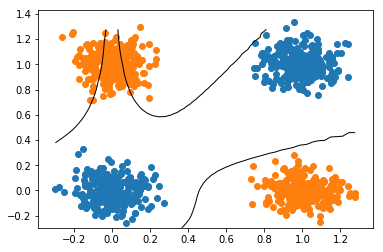

In [11]:
min_x_val = min(x_1.min(), x_2.min())
max_x_val = max(x_1.max(), x_2.max())

min_y_val = min(x_1.min(), x_2.min())
max_y_val = max(x_1.max(), x_2.max())

x_, y_ = np.meshgrid(np.linspace(min_x_val, max_x_val, 50), np.linspace(min_y_val, max_y_val, 50))

u = np.linspace(min_x_val, max_x_val, 50)
data = []
for i in range(50):
    v = y_[i,:]
    poly = []
    for i in range(deg):
        poly.append((u**(deg-i))*(v**i))
    
    xs = np.array([np.ones(u.shape)]+poly)
    p = softmax(np.array(theta.x).reshape(2,-1).dot(xs))
    data.append(p[0,:])
data = np.vstack(data)

ax = plt.axes()
ax.scatter(x1, y1)
ax.scatter(x2, y2)
plt.contour(x_, y_, data, [0.5], linewidths=1, colors='k')
plt.show()

We can get decent accuracy on this problem using non-linear features (and in fact, for simpler problems such as data in a concentric pattern, this is enough to solve them), though when visualizing the decision boundary, we can see that there are still areas that aren't well classified. One way around this would be to find a feature representation that better matches the data, which requires human expertise; another way would be to find a more expressive function approximator that can separate this type of data. Neural networks, are one such type of function approximator. In the next section, we'll use them to classify images to demonstrate some of their powerful function approximation capabilities.

## 5. Neural Network Classification

You knew this was coming! The primary difference between a logit classifier and a neural network classifier is the weight parameterization. A neural network can have softmax or sigmoid outputs, but has many more weight layers in the network.

For this task, we will put together a simple handwritten digit classifier. We can download the MNIST handwritten digits dataset through torch, and plot an example to see what it looks like:

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

batch_size = 256
test_batch_size = 4

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('../data', train=True, download=True, transform=transform),
                batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
                datasets.MNIST('../data', train=False, transform=transform),
                batch_size=test_batch_size, shuffle=True)

We'll visualize a few examples from the test loader to get an idea of the task:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


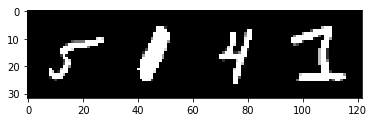

Given labels are:  [5 1 4 1]


In [17]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print("Given labels are: ", labels.numpy())

Next, we'll build our neural network classifier. We'll use a softmax output, and we'll use nn.Sequential instead of inheriting directly from nn.Module. Our images are $28\times28$ pixels, which gives us a total size of 784:

In [18]:
input_dim = 784
hidden_dim = 128
output_dim = 10

softmax_classifier = nn.Sequential(
                    nn.Linear(input_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, output_dim),
                    nn.LogSoftmax(dim=-1))

Finally, we'll train it up using a standard SGD optimizer, and then check its accuracy. Since we're using a real dataset, we'll exercise good practice, and use a train set and a test set split (you don't want to overfit your data):

In [19]:
def plot(iteration, loss):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title("iter %s. loss: %s" % (iteration[-1], loss[-1]))
    plt.plot(iteration, loss)
    plt.show()

def train(model, optimizer, loss_function, dataset, iters=10, log_freq=1):
    model.train()
    ep, cost = [], []
    for i in range(1, iters+1):
        mean_loss = 0.
        for j, (data, target) in enumerate(dataset):
            data = data.squeeze(dim=1)
            pred_ys = model(data.view(data.size(0),-1))
            loss = loss_function(pred_ys, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            mean_loss = (mean_loss*j+loss.item())/(j+1)
        if i % log_freq == log_freq-1:
            ep.append(i)
            cost.append(mean_loss)
            plot(ep, cost)
            
def test(model, dataset):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataset:
            data = data.squeeze(dim=1)
            output = model(data.view(data.size(0),-1))
            test_loss += F.nll_loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Finally, we'll plot a few examples along with their predictions:

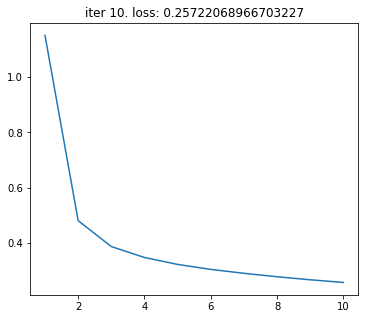


Test set: Average loss: 0.0610, Accuracy: 9305/10000 (93%)



In [20]:
optimizer_softmax = optim.SGD(softmax_classifier.parameters(), lr=1e-3, momentum=0.9)
train(softmax_classifier, optimizer_softmax, F.nll_loss, train_loader)
test(softmax_classifier, test_loader)

We visualize a few of these predictions in the following block of code:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


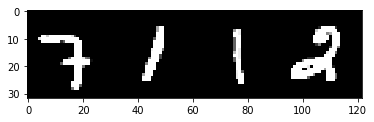

Predicted labels are:  [7 1 1 2]


In [21]:
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
images.squeeze(dim=1)
_, output = torch.max(softmax_classifier(images.view(images.size(0),-1)), dim=1)
print("Predicted labels are: ", output.numpy())

We manage to get pretty decent accuracy even with a very simple network!

## 6. Convolutional Neural Networks

In the previous example, the value of each pixel was an input into the network. This is feasible when we have small images, but could quickly explode the number of parameters we need to learn for very large pictures (say, in the megapixel range). As the number of parameters explodes, so too does the search space, making such networks very difficult to train. So how do we do machine learning tasks on very large pictures? The answer is convolution.

### 6.1 What Is Convolution?

You would have encountered convolution in engineering maths (the Fourier transform module). Convolutions can be thought of as a measure of similarity between two vector spaces. Visually, we can see what a convolution between two functions is doing below:

![alt text](img/convolution_1.gif)

![alt text](img/convolution_2.gif)

In the first image, a square wave is convolved with itself. When it is fully superimposed over itself, the output of the convolution is 1. As it moves across the function, it gets more and more similar until it peaks at the maximum, and then it starts to decrease again. Similarly, the second convolution peaks as the left edge of the square wave aligns with the left edge of the sharp wave function, since this is the point at which they are most similar (they have the most overlapping area).

How is this useful? Well, we can use it to learn a filter that then lets us detect certain objects in an image. Our filter is just a set of weights, as in a standard neural network, in an $n \times n$ matrix. We scan this filter over the image to see if there are any regions that are very similar. We do this many times with many filters, and our network outputs a prediction as to what object was in the image. We then use supervised learning to train the filters to detect features that help our network improve its predictions. This sounds like a lot, so here's an animation of what this process looks like:

![alt text](img/convSobel.gif)

This single idea is the funamental basis of modern deep image classification, and has been used to play computer games using nothing but pixel representation. In the code below, we'll implement a very simple CNN in PyTorch. This time, we'll use CIFAR10, which has 10 classes to classify: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

### 6.2 An Implementation

First, we'll import our dataset the same way we did with MNIST:

In [22]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Next, we'll write a quick function to visualize the data, so that we can visually validate the network's performance. We'll also show a few examples to test it out:

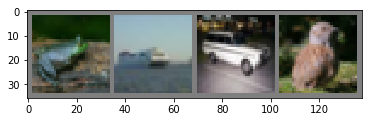

 frog  ship   car  bird


In [23]:
def imshow(img):
    img = img/2+0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s'%classes[labels[j]] for j in range(4)))

Below, we define a 2D convolutional neural net with a kernel size of 5:

In [24]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(18 * 16 * 16, 64)
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 18 * 16 *16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)

net = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

And now we train it. This takes a while, so we'll only do two iterations:

In [25]:
for epoch in range(2):
    running_loss = 0.
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f'%(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.875
[1,  4000] loss: 1.542
[1,  6000] loss: 1.412
[1,  8000] loss: 1.373
[1, 10000] loss: 1.313
[1, 12000] loss: 1.273
[2,  2000] loss: 1.194
[2,  4000] loss: 1.162
[2,  6000] loss: 1.146
[2,  8000] loss: 1.130
[2, 10000] loss: 1.145
[2, 12000] loss: 1.124
Finished Training


Now to test it:

In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%'%(100*correct/total))

Accuracy of the network on the 10000 test images: 59 %


That's... not the best accuracy, but the fact that it gets any correct at all is quite good given that we have 10 classes. The expected random accuracy is 10%, and we beat that pretty comfortably with a toy network.

In practice, much more sophisticated networks than this one are used for image classification tasks. In fact, very large convnets are some of the biggest neural nets in existence, with billions of parameters. To train them, it's standard to use a cluster of GPUs, or -- more recently -- TPUs. The accuracy of these classifiers is also very good -- typically on the order of 97-99% for the state-of-the-art. 

## 7. Summary
In this notebook, we have covered the basics of classification, first using classical methods to classify simple, separable datasets, and then using neural networks for image classification on known datasets. This code should be used as a stepping-stone to more complex models; for example, 2D convolutional neural nets can learn filters to detect given objects. Video footage is simply a stack of 2D images, so we could use a 3D convnet to detect, say, sharks from a drone by using footage of them swimming. Or how about detecting hardware faults in aircraft? This is a difficult task due the sparsity (a few seconds of fault for potentially thousands of hours of standard operation), but could be useful in future aircraft.

In terms of the current state-of-the-art, we have classifiers now that are able to classify thousands of objects at roughly human-level accuracy. The weaknesses of current classifiers include things like detecting context, and resisting adversarial attacks (we can attack a network by generating a series of pixels that the network mis-classifies). These are open and active research areas.